In [1]:
# import relevant libraries 
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [46]:
class HouseInfo:
    """
    Class to define a cell in grid as a house and store relevant information.
    """
    def __init__(self, UrbanGrid):
        """
        Initiliaze attributes of house:
        - house_type: type of house (either "vacant or "occupied")
        - occupied: boolean True is "occupied", False otherwise
        - current_utility: utility of being in current location
        - race: either pink or green, with a uniform probability of being either
        - net_wealth: the net wealth of the houseowner if house is occupied
        - land_value: the value of the house, initialized to 25-40% of owner's net wealth (DWA, 2021) or such percentage of random variable #https://deltawealthadvisors.com/blog/what-percentage-of-net-worth-should-be-in-real-estate
        """
        self.house_type = "occupied" if random.random() < UrbanGrid.density else "vacant" # house is occupied at a specific density rate
        self.occupied = self.house_type == "occupied" # self.occupied is true iff the house is labeled as "occupied"
        self.current_utility = None # store the utilities

        if self.occupied:
            self.race = random.choice(["pink", "green"])
            self.net_wealth = UrbanGrid.initialize_wealth(self)
            self.land_value = self.net_wealth*random.uniform(0.25, 0.4)
        else:
            self.race = None
            self.net_wealth = None
            self.land_value = random.uniform(0.25, 0.4) * np.mean((np.random.pareto(2.0, 20) * (3800 * random.uniform(1, UrbanGrid.wealth_diff)))) # random range within the values of green and pink wealth


class UrbanDynamics:
    """
    Class to store grid information and moves accordingly.
    """
    def __init__(self, racial_preference, wealth_diff = 2, grid_size = 10, density = 0.7, utility_threshold = 1):
        """
        Initialize attributes of grid:
        - self.racial_preference: The proportion of neighboring cells that must be of the same race for house-owner to be happy
        - self.grid_size: length and width of square grid (eg. grid_size = 10, grid cells = 10^2 = 100)
        - self.density: density of occupied houses in grid space (initialized to 0.7)
        - self.wealth_diff: The ratio of wealth between the pink and green races (used in Pareto distribution) (eg. wealth_diff = 2 means 2:1 relationship pink:green)
        - self.grid: Grid to store house agents
        - self.vacant_houses & self.occupied_houses: List of coordinates of currently vacant and occupied houses, respectively
        - self.moving_threshold: Threshold for moving if agent is unhappy (Monte-Carlo simulation process)
        - self.move_per_step: List of movements in one step in order to check convergence
        - self.landval_similarity: List of mean neighborhood land value similarity at each time step
        - self.race_similarity: List of mean neighborhood race similarity at each time step
        - self.proportion_happy: List of the proportion of households with a current utility > utility threshold at each time step
        - self.neighbors: Dictionary of neighbors list for each coordinate in grid (since we assume cut-off boundaries)
        - self.steps: step count
        """
        self.racial_preference = racial_preference
        self.grid_size = grid_size
        self.density = density
        self.wealth_diff = wealth_diff #based on 1950s US census data https://www2.census.gov/library/publications/1952/demographics/p60-09.pdf
        self.grid = [[HouseInfo(self) for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        self.utility_threshold = utility_threshold
        self.vacant_houses = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size) if not self.grid[x][y].occupied]
        self.occupied_houses = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size) if self.grid[x][y].occupied]
        self.moving_threshold = 0.5
        self.move_per_step = []
        self.landval_similarity = []
        self.race_similarity = []
        self.neighbors = {(x, y): self.count_neighbors((x, y)) for x in range(self.grid_size) for y in range(self.grid_size)}
        self.steps = 0
        self.proportion_happy = []
        self.movement_count = 0 

    def initialize_wealth(self, house_owner):
        """
        Initialize the wealth of individuals depending on their race and the parameters set.
        """
        scale = 3800 # scale that returns a median of 1600
        alpha = 2.0
        years_saved = 20 # assuming 20 years of earning = net wealth
        if house_owner.race == "pink":
            return np.mean(np.random.pareto(alpha, years_saved) * (scale*self.wealth_diff)) # assume pareto distribution, where 80% own 20% of money in an economy
        else:
            return np.mean(np.random.pareto(alpha, years_saved) * (scale))

    def count_neighbors(self, grid_position):
        """
        Initialize the number of neighbors at each grid position. (Speed up computations later)
        """
        x, y = grid_position
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size and (dx != 0 or dy != 0):
                    neighbors.append((nx, ny))
        return neighbors

    def calculate_utility(self, grid, grid_position):
        """
        Calculate the utility of living in a specific cell.
        """
        x, y = grid_position
        same_race_count = 0
        av_neighbor_land_value = 0
        for nx, ny, in self.neighbors[(x, y)]:
            av_neighbor_land_value += grid[nx][ny].land_value / len(self.neighbors[(x, y)]) # calculate average value of neighbor's land
            if grid[nx][ny].occupied and grid[nx][ny].race == grid[x][y].race:
                same_race_count += 1 # sum neighbors with the same race as current houseowner
        # calculate utilities
        race_utility = 1 if same_race_count / len(self.neighbors[(x, y)]) >= self.racial_preference else 0 # race utility as defined by self.racial_preference

        ideal_house_val = grid[x][y].net_wealth * random.uniform(0.25, 0.4) # calculate the "ideal" house value as 25-40% on the houseowner income
        house_val_diff = (abs(av_neighbor_land_value - ideal_house_val) / ((ideal_house_val))) # calculate the proportion difference of
        land_value_utility = 0 if house_val_diff > 1 else (1-house_val_diff ) # the utility from neighbors with house values with greater than 100% difference will be 0, otherwise, utility will decay linearl
        # Sum and return the total utility (0 <= utility <= 2)
        self.grid[x][y].current_utility = race_utility + land_value_utility # max value can be 2 (if all neighbors are the same and the wealth diff =0)
        return self.grid[x][y].current_utility



    def calculate_all_utilities(self):
        """
        Calculate the utility of all positions in the grid.
        """
        for (x, y) in self.occupied_houses:
            if self.grid[x][y].occupied:  # only occupied houses are able to determine utility
                self.grid[x][y].current_utility = self.calculate_utility(self.grid, (x, y))
            else:
                self.grid[x][y].current_utility = None

    def update_house_states(self):
        """
        Update the list of coordinates of vacant houses.
        """
        self.vacant_houses = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size) if not self.grid[x][y].occupied]
        self.occupied_houses = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size) if self.grid[x][y].occupied]


    def move_one_step(self, grid_position, current_position_utility):
        """
        Check the house to move or not.
        """
        x, y = grid_position
        if current_position_utility < self.utility_threshold:  # if not happy
            if random.random() < self.moving_threshold: # possibility of moving
                maybe_new_x, maybe_new_y = random.choice(self.vacant_houses)
                self.grid[maybe_new_x][maybe_new_y], self.grid[x][y] = self.grid[x][y], self.grid[maybe_new_x][maybe_new_y]
                #self[x][y] = self.grid[maybe_new_x][maybe_new_y]
                if self.calculate_utility(self.grid, (maybe_new_x, maybe_new_y)) > current_position_utility : #and 0.3*(self.grid[x][y].net_value) >= (self.grid[maybe_new_x][maybe_new_y].land_value)
                    # Move the resident to the new location
                    # Update the list of vacant houses
                    self.update_house_states() #print("the new utility:", self.calculate_utility(self.grid, (maybe_new_x, maybe_new_y)), "is greater, therefore, we move to", )
                    self.movement_count += 1
                else:
                    # Move the resident back to old houme
                    self.grid[maybe_new_x][maybe_new_y], self.grid[x][y] = self.grid[x][y], self.grid[maybe_new_x][maybe_new_y]
            else:
                return
        else:
            return

    def move_all_one_step(self):
        """
        Query 20% of occupied households to prompt a possible move.
        """
        # count how many house moves are made in the queries
        self.movement_count = 0
        # randomly query ~20% of the population to initiate a possible move
        for i in range(int(0.2*self.density*self.grid_size**2)): # (https://www.pewresearch.org/social-trends/2008/12/17/who-moves-who-stays-put-wheres-home/)
            (x, y) = random.choice(self.occupied_houses)
            self.calculate_utility(self.grid, (x, y))
            self.move_one_step((x, y), self.grid[x][y].current_utility)
        self.move_per_step.append(self.movement_count)

    def update_house_values(self, diffusion_rate=0.2):
        """
        Update house values based on the average neighborhood value.
        Houses in lower-income neighborhoods lose some value, whereas houses in higher-income neighborhoods gain value.
        """
        updated_land_vals = np.zeros((self.grid_size, self.grid_size))
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                neighbors_land_value = 0

                # calculate the average land value of neighbors
                neighbors_land_value = np.sum([self.grid[nx][ny].land_value for (nx, ny) in self.neighbors[(x, y)]])
                average_neighbor_value = neighbors_land_value / len(self.neighbors[(x, y)])

                # adjust house value based on neighborhood value
                if self.grid[x][y].land_value > average_neighbor_value:
                    # house loses value in a lower-income neighborhood
                    updated_land_vals[x][y] = self.grid[x][y].land_value - diffusion_rate * (self.grid[x][y].land_value - average_neighbor_value)
                else:
                    # house gains value in a higher-income neighborhood
                    updated_land_vals[x][y]= self.grid[x][y].land_value + diffusion_rate * (average_neighbor_value - self.grid[x][y].land_value)
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                self.grid[x][y].land_values = updated_land_vals[x][y] # make all changes at once

    def update_step(self):
        """
        Update for one step. 
        """
        self.move_all_one_step()
        self.update_house_values()
        self.measure_segregation()
        self.proportion_happy.append(np.mean([1 if self.grid[x][y].current_utility >= self.utility_threshold else 0 for (x,y) in self.occupied_houses]))
        self.steps += 1
    def measure_segregation(self):
        """
        Measure the landval and racial segregation by checking similarity values. 
        """
        total_racial_similarity = 0
        total_landval_similarity = 0
        occupied_count = 0

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                neighbors_land_value = 0
                same_race_count = 0
            if self.grid[x][y].occupied: # measure racial segregation levels of only occupied houses
                for nx, ny in self.neighbors[(x, y)]: # check the similarity of all neighbors...
                    neighbors_land_value += self.grid[nx][ny].land_value # land values
                    if self.grid[nx][ny].occupied and self.grid[nx][ny].race == self.grid[x][y].race: # race
                        same_race_count += 1
                    else:
                        for nx, ny in self.neighbors[(x, y)]: # check the similarity of all neighbors...
                            neighbors_land_value += self.grid[nx][ny].land_value # land values

                    mean_neighborhood_value = neighbors_land_value / len(self.neighbors[(x, y)])
                    landval_similarity = 1 - (abs(self.grid[x][y].land_value - mean_neighborhood_value) / mean_neighborhood_value)# determine the similarity level of average wealth and individual's elalth
                    total_landval_similarity += landval_similarity if landval_similarity >= 0 else 0
                    total_racial_similarity += same_race_count / len(self.neighbors[(x, y)])

        mean_land_val_similarity = total_landval_similarity / (self.grid_size**2) # Calculate the mean land value similarity at time step
        mean_racial_similarity = total_racial_similarity / len(self.occupied_houses) # Calculate the mean racial similarity at time step
        self.landval_similarity.append(mean_land_val_similarity )
        self.race_similarity.append(mean_racial_similarity)
        return mean_land_val_similarity, mean_racial_similarity


    def visualize_landval_distribution(self):
        """
        Create a visualization of the land values in the grid. 
        """
        # initizalize grid 
        landval_grid = np.zeros((self.grid_size, self.grid_size))
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                # save current land value to grid 
                landval_grid[x][y] = self.grid[x][y].land_value

        plt.figure(figsize=(8, 8))
        plt.title(f"Land Value Distribution at Step: {self.steps-1}")
        plt.imshow(landval_grid, cmap='Greens', vmin=0, vmax=5000)  # Adjust vmin and vmax as needed
        plt.colorbar(label='Land Value', shrink = 0.75)
        plt.show()

    def visualize_racial_distribution(self):
        """
        Create a visualization of the racial distributions in the grid 
        """
        race_grid = np.zeros((self.grid_size, self.grid_size))
        # initizalize grid 
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x][y].occupied:
                    # save the current race of the occupied house
                    race_grid[x][y] = 1 if self.grid[x][y].race == 'pink' else 2
                else:
                    # otherwise, the grid position takes on value 0, indicating empty 
                    race_grid[x][y] = 0

        # define the colormap
        cmap = mcolors.ListedColormap(['black', 'pink', 'green'])  # black for vacant, pink, and green for races
        bounds = [0, 1, 2, 3]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        plt.figure(figsize=(8, 8))
        plt.title(f"Racial Distribution at Step: {self.steps-1}")
        plt.imshow(race_grid, cmap=cmap, norm=norm)
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=[0.5, 1.5, 2.5], label='Race', shrink =0.75)
        cbar.set_ticklabels(['Vacant', 'Pink', 'Green'])
        plt.show()



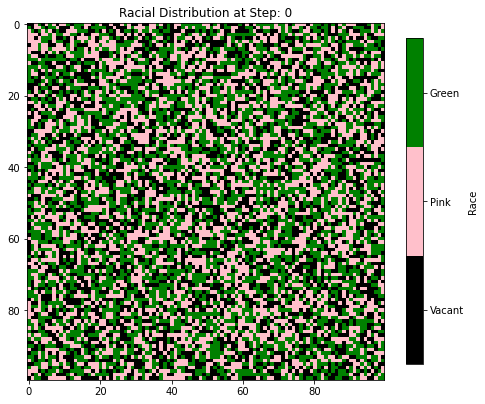

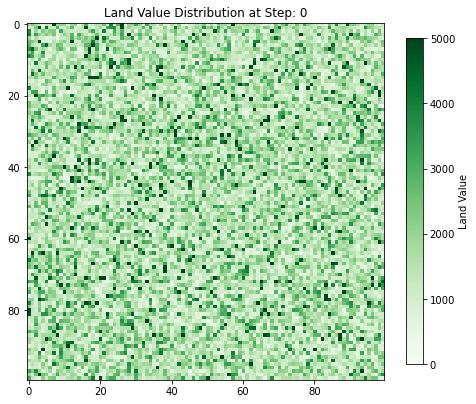

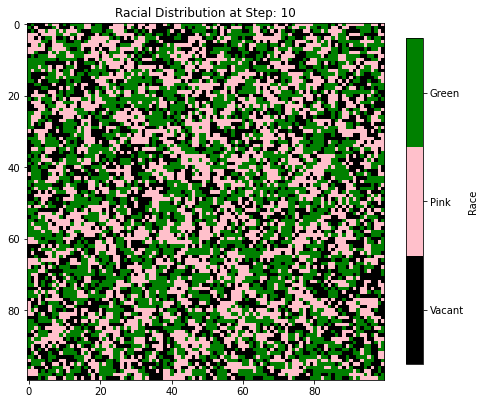

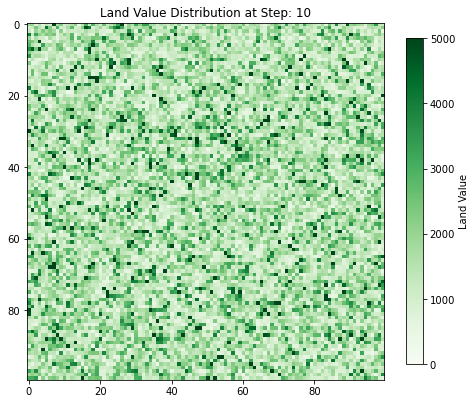

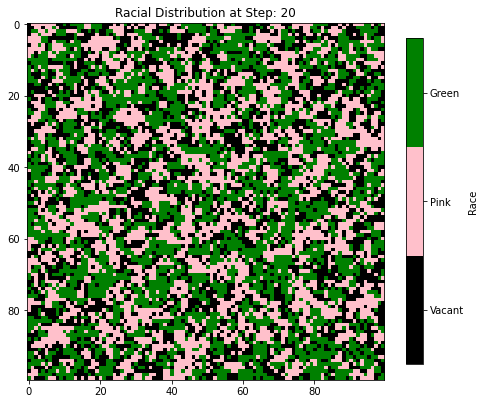

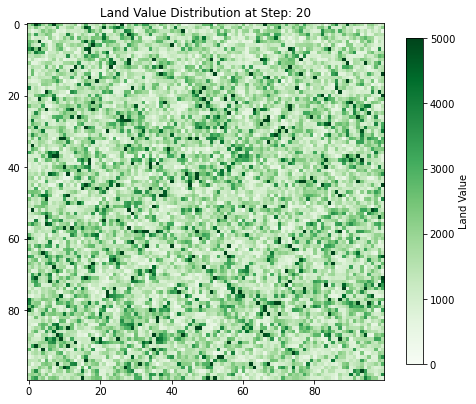

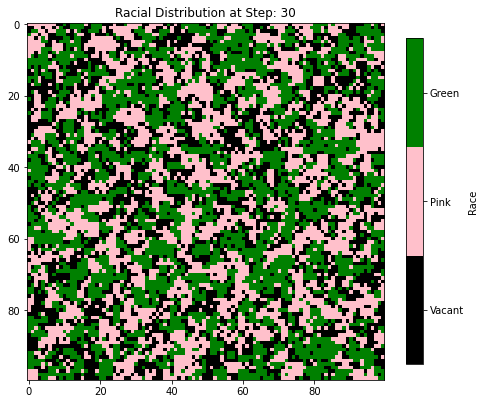

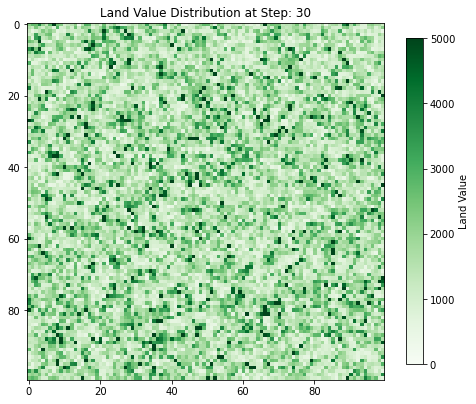

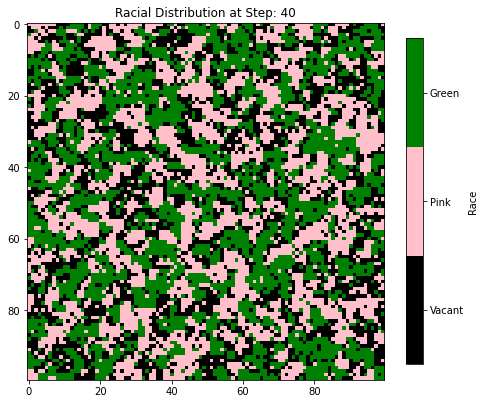

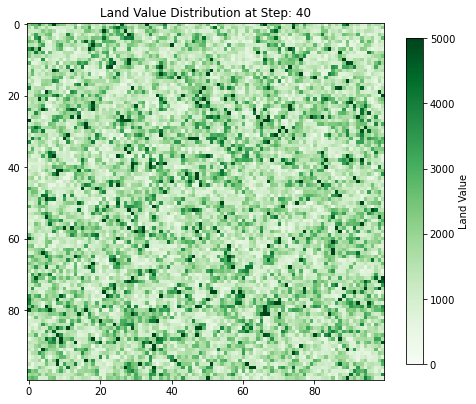

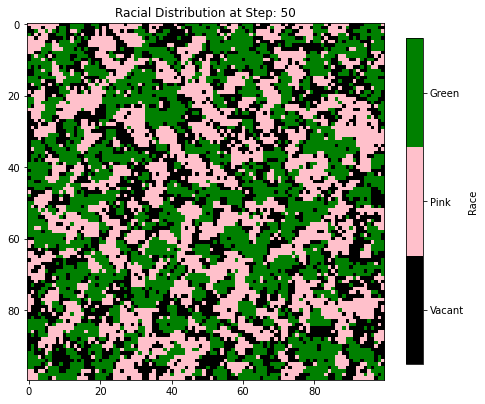

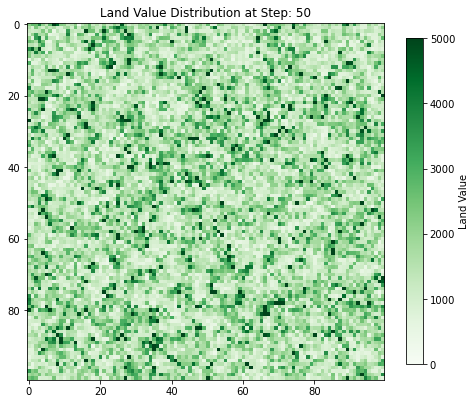

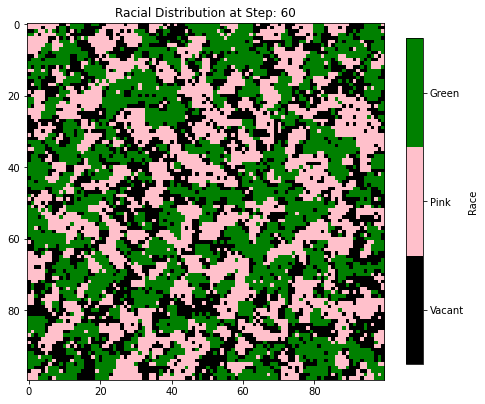

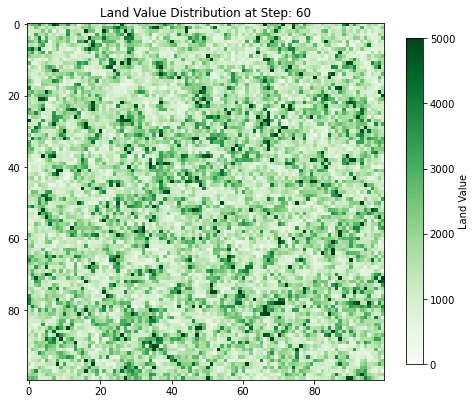

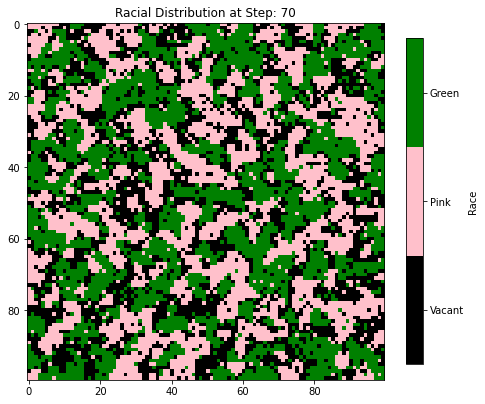

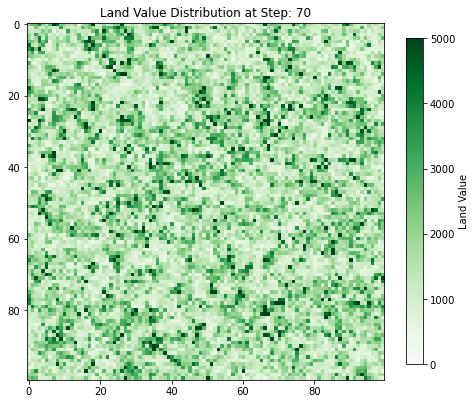

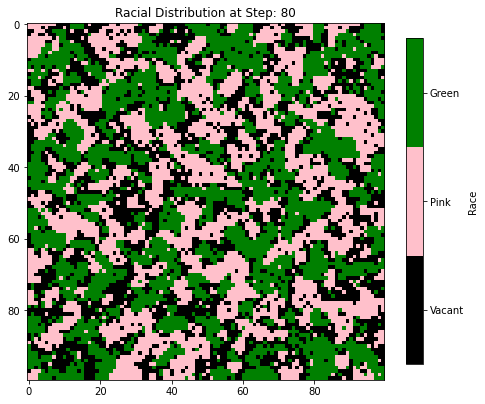

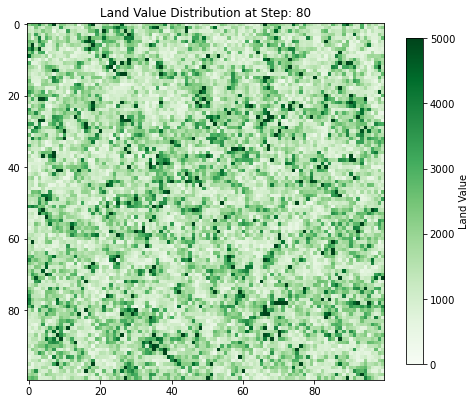

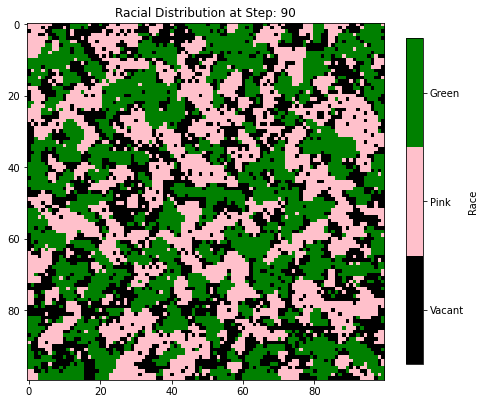

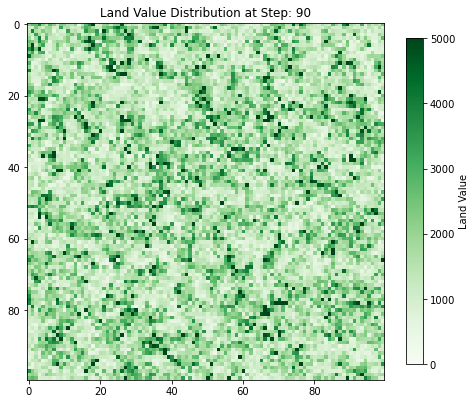

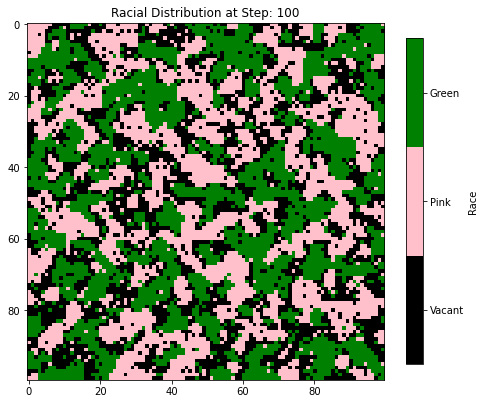

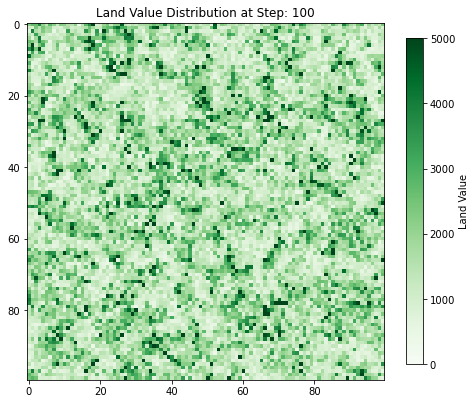

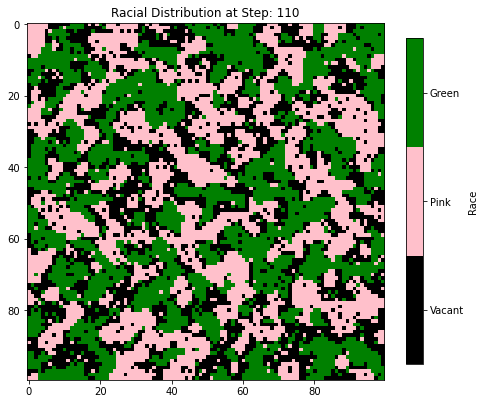

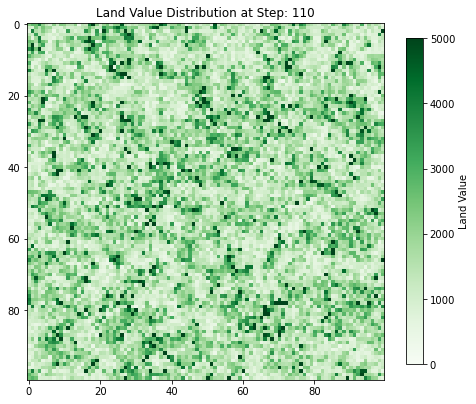

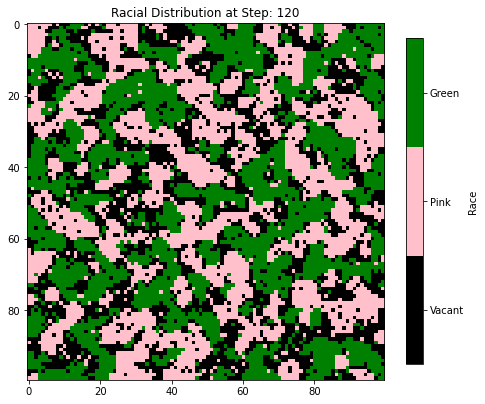

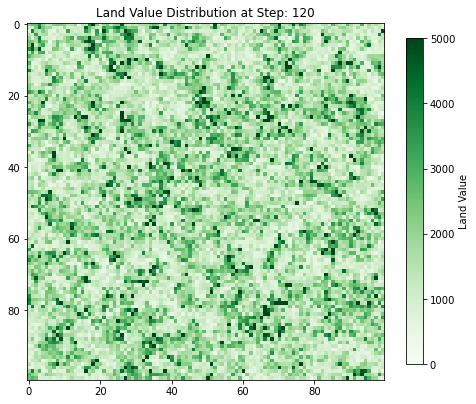

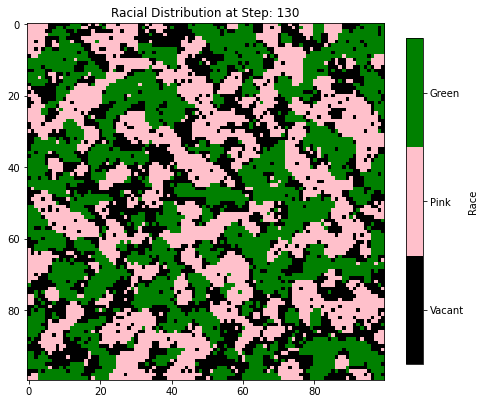

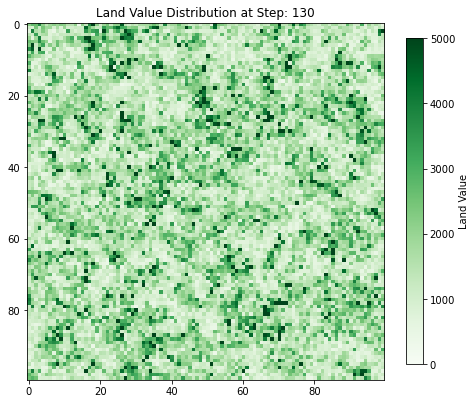

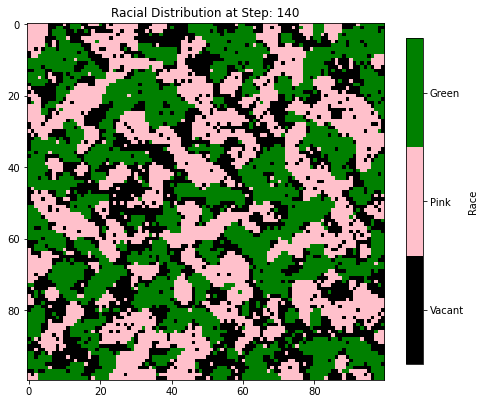

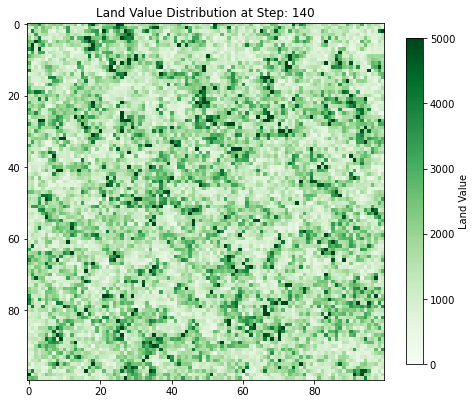

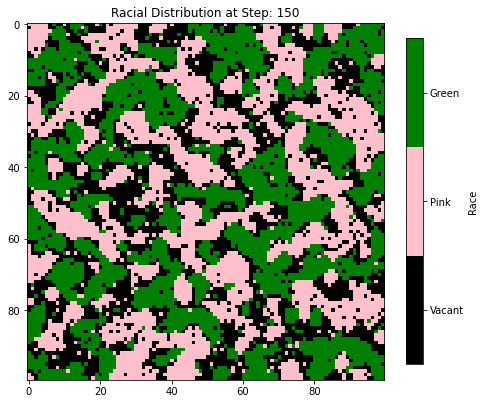

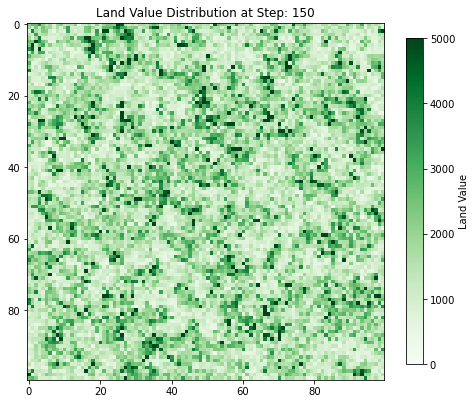

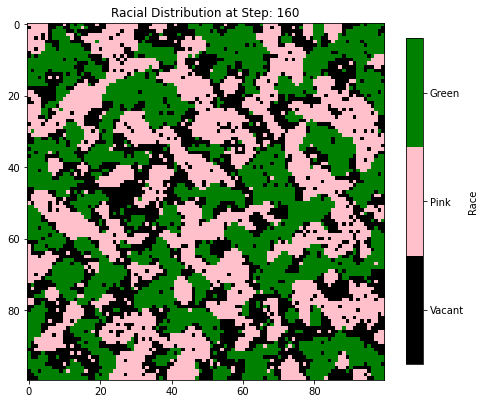

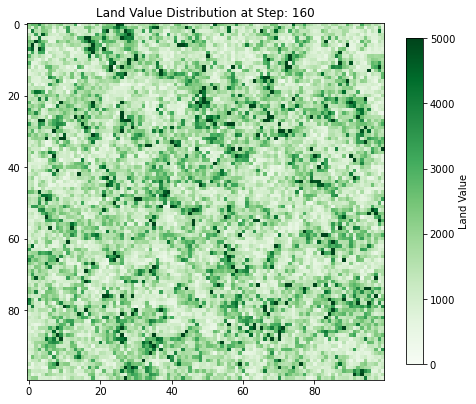

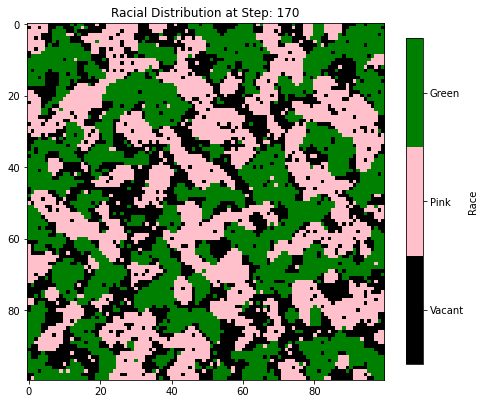

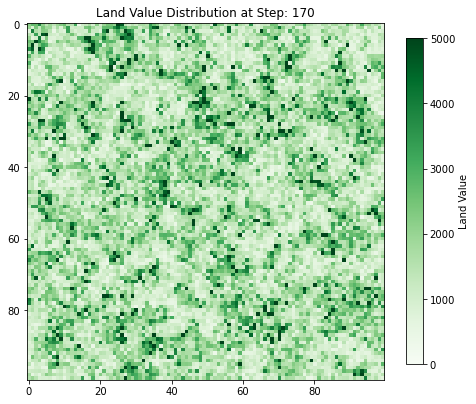

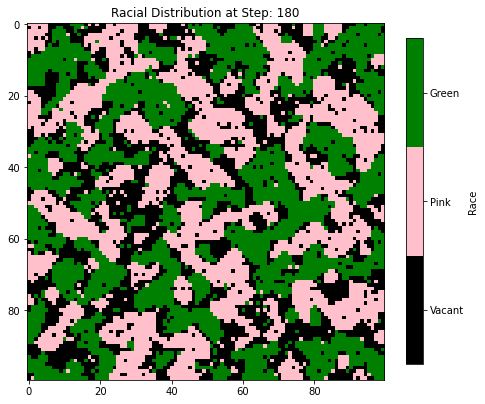

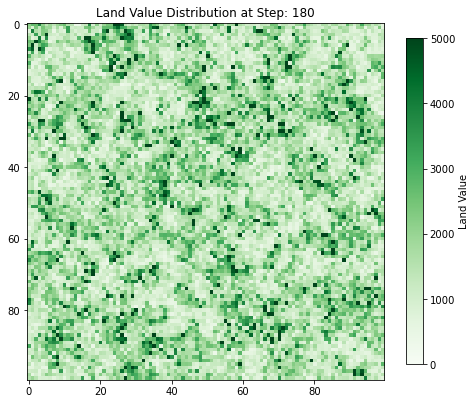

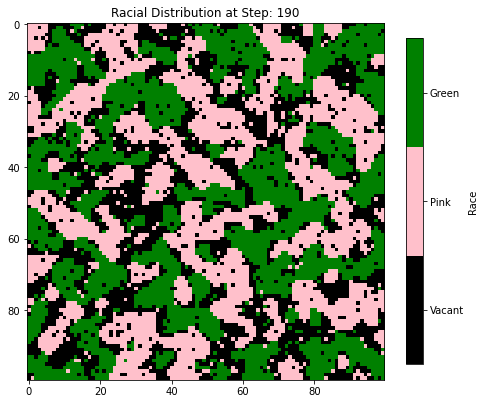

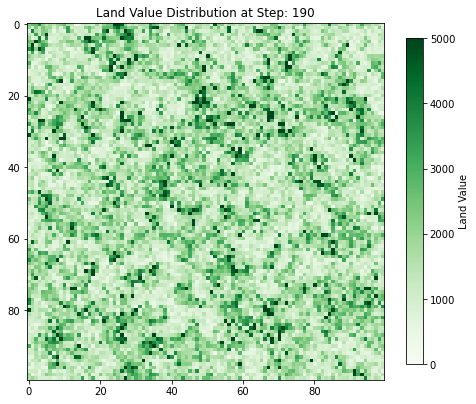

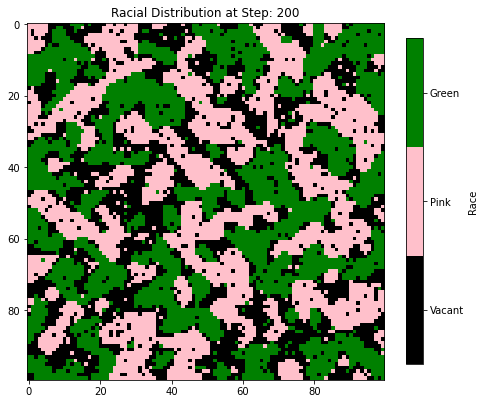

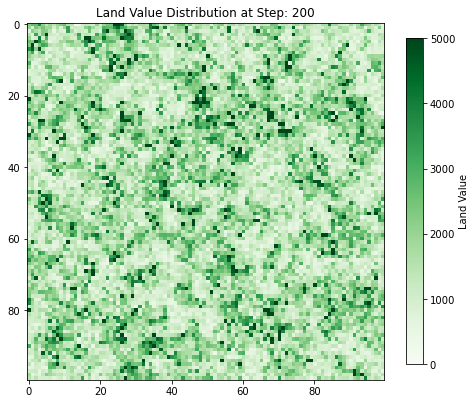

In [30]:
# DISPLAY GRID 
urban_dynamics_sim = UrbanDynamics(racial_preference=0.5, wealth_diff=2, utility_threshold=1.5, grid_size =100)
urban_dynamics_sim.calculate_all_utilities()

for step in range(201):
    urban_dynamics_sim.update_step()
    if step % 10 == 0: 
        urban_dynamics_sim.visualize_racial_distribution()
        urban_dynamics_sim.visualize_landval_distribution()

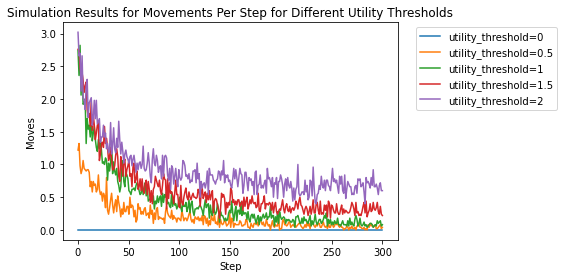

In [19]:
# run an initial simulation to check "how" long it takes for the system to converge for different parameter values: 

def find_equilibrium(parameter_values, trials=50, grid_size=10, steps=300): 
    """
    Find steadt states for different utility thresholds
    """
    all_results = []
    for utility_threshold_val in parameter_values: 
        parameter_results = np.zeros(steps)
        for _ in range(trials): 
            urban_dynamics_sim = UrbanDynamics(racial_preference=0.5, wealth_diff=2, utility_threshold = utility_threshold_val, grid_size=grid_size)
            urban_dynamics_sim.calculate_all_utilities()
            for _ in range(steps): 
                urban_dynamics_sim.update_step()
            parameter_results += np.array(urban_dynamics_sim.move_per_step)
        all_results.append((parameter_results/trials))
    
    #plot graph 
    step_list = np.linspace(0, steps, steps)
    for i in range(len(parameter_values)): 
        plt.plot(step_list, all_results[i], label=f"utility_threshold={parameter_values[i]}")
    plt.title("Simulation Results for Movements Per Step for Different Utility Thresholds")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel("Step")
    plt.ylabel("Moves")
    plt.show()

utility_threshold_values = [0, 0.5, 1, 1.5, 2]
find_equilibrium(utility_threshold_values)



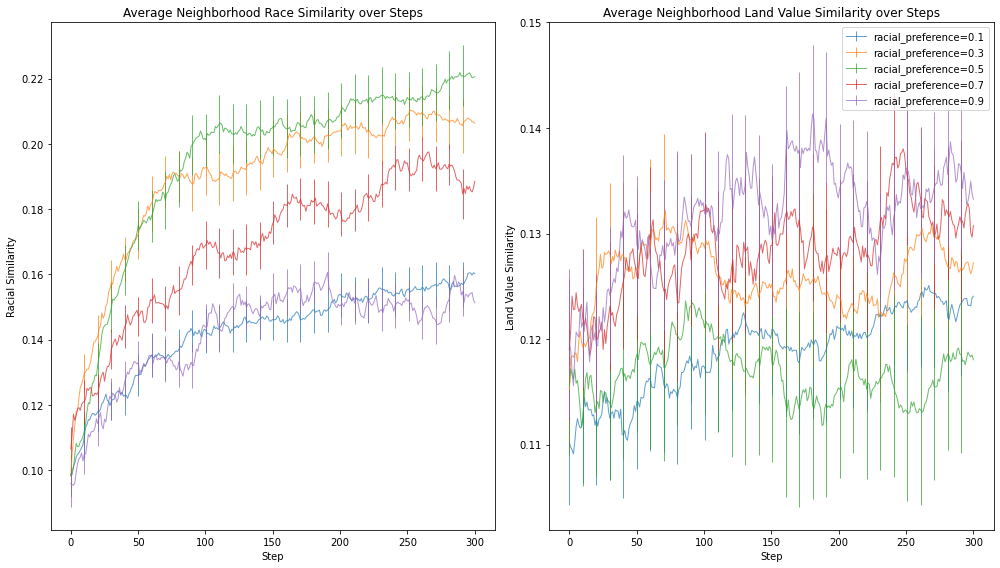

In [57]:
# determine the equilibrium states of racial preference + change per step 
from scipy.stats import sem

def simulate_diff_racial_preference(parameter_values, trials=100, grid_size=10, steps=300, utility_threshold=1.5):
    """
    Simulate different racial preferences, and racial similarity and land value similarity changes over time. 
    """
    # store every step value 
    all_race_results = []
    all_landval_results = []
    
    # store standard errors 
    all_race_sems = []
    all_landval_sems = []
    
    # store final average similarity values after all steps 
    final_race_similarities = {val: [] for val in parameter_values}
    final_landval_similarities = {val: [] for val in parameter_values}
    
    # check every parameter value 
    for racial_preference_val in parameter_values:
        trial_race_results = []
        trial_landval_results = []
        for _ in range(trials):
            # create a new grid and initialize 
            urban_dynamics_sim = UrbanDynamics(racial_preference=racial_preference_val, wealth_diff=2, utility_threshold=utility_threshold, grid_size=grid_size)
            urban_dynamics_sim.calculate_all_utilities()
            
            # initialize 
            race_results_per_trial = []
            landval_results_per_trial = []
            for step in range(steps):
                urban_dynamics_sim.update_step()
                race_results_per_trial.append(urban_dynamics_sim.race_similarity[step])
                landval_results_per_trial.append(urban_dynamics_sim.landval_similarity[step])
            trial_race_results.append(race_results_per_trial)
            trial_landval_results.append(landval_results_per_trial)
            # save the final similarity measures
            final_race_similarities[racial_preference_val].append(urban_dynamics_sim.race_similarity[-1])
            final_landval_similarities[racial_preference_val].append(urban_dynamics_sim.landval_similarity[-1])
        
        
        trial_race_results = np.array(trial_race_results)
        trial_landval_results = np.array(trial_landval_results)

        all_race_results.append(np.mean(trial_race_results, axis=0))
        all_landval_results.append(np.mean(trial_landval_results, axis=0))

        all_race_sems.append(sem(trial_race_results, axis=0))
        all_landval_sems.append(sem(trial_landval_results, axis=0))
        
    return all_race_results, all_landval_results, all_race_sems, all_landval_sems, final_race_similarities, final_landval_similarities



# define the parameter values 
racial_preference_values = [0.1, 0.3, 0.5, 0.7, 0.9]
race_similarity_results, landval_similarity_results, race_sems, landval_sems, final_race_results, final_landval_results = simulate_diff_racial_preference(racial_preference_values)

steps = 300
x_values = np.linspace(0, steps, steps)

# create separate plots for race similarity and land value similarity
plt.figure(figsize=(14, 8))

# function to thin out error bars for easier visibility
def thin_out_error_bars(sems, step=10):
    return [sem if i % step == 0 else 0 for i, sem in enumerate(sems)]
# plot race Similarity
plt.subplot(1, 2, 1)
plt.title("Average Neighborhood Race Similarity over Steps")
plt.xlabel("Step")
plt.ylabel("Racial Similarity")

for i, racial_preference in enumerate(racial_preference_values):
    plt.errorbar(x_values, race_similarity_results[i], yerr=thin_out_error_bars(1.96 * landval_sems[i]), 
                 label=f"racial_preference={racial_preference}", alpha=0.7, fmt='-', linewidth=1)

# plot land value similarity
plt.subplot(1, 2, 2)
plt.title("Average Neighborhood Land Value Similarity over Steps")
plt.xlabel("Step")
plt.ylabel("Land Value Similarity")
for i, racial_preference in enumerate(racial_preference_values):
    plt.errorbar(x_values, landval_similarity_results[i], yerr=thin_out_error_bars(1.96 * landval_sems[i]), 
                 label=f"racial_preference={racial_preference}", alpha=0.7, fmt='-', linewidth=1)

plt.legend()
plt.tight_layout()
plt.show()


Racial Preference 0.1: Mean = 0.16, 95% CI = (0.15, 0.17)


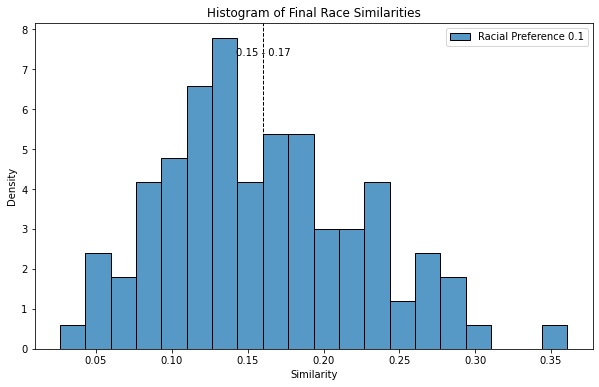

Racial Preference 0.3: Mean = 0.21, 95% CI = (0.19, 0.22)


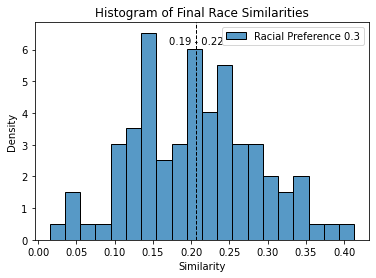

Racial Preference 0.5: Mean = 0.22, 95% CI = (0.20, 0.24)


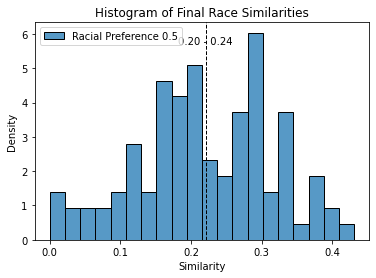

Racial Preference 0.7: Mean = 0.19, 95% CI = (0.17, 0.20)


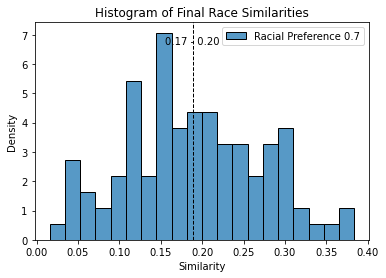

Racial Preference 0.9: Mean = 0.15, 95% CI = (0.14, 0.16)


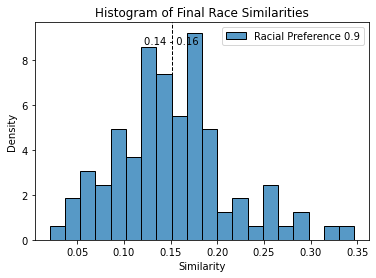

Racial Preference 0.1: Mean = 0.12, 95% CI = (0.12, 0.13)


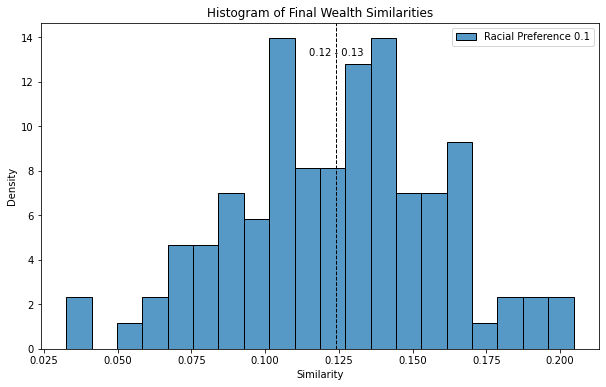

Racial Preference 0.3: Mean = 0.13, 95% CI = (0.12, 0.14)


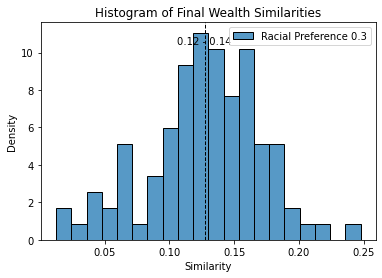

Racial Preference 0.5: Mean = 0.12, 95% CI = (0.11, 0.13)


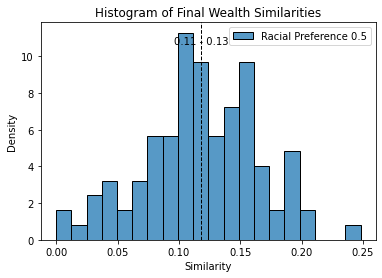

Racial Preference 0.7: Mean = 0.13, 95% CI = (0.12, 0.14)


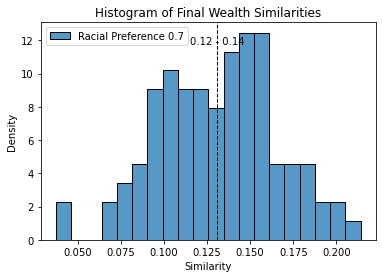

Racial Preference 0.9: Mean = 0.13, 95% CI = (0.13, 0.14)


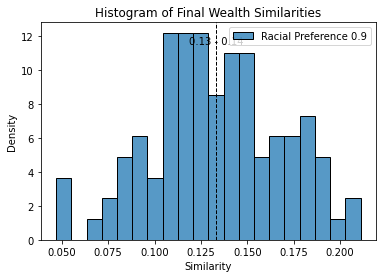

In [59]:

from scipy.stats import t
import seaborn as sns

# calculate 95% confidence intervals
def calculate_95CI(data):
    mean = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + 0.95) / 2, len(data) - 1)
    return mean, mean-h, mean+h

# histograms with confidence intervals
def plot_histograms_with_CI(results, title):
    plt.figure(figsize=(10, 6))
    for pref, data in results.items():
        sns.histplot(data, label=f"Racial Preference {pref}", kde=False, bins=20, stat="density")
        mean, lower, upper = calculate_95CI(data)
        plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        plt.text(mean, plt.ylim()[1]*0.9, f'{lower:.2f} - {upper:.2f}', rotation=0, color='k', ha='center')
        print(f"Racial Preference {pref}: Mean = {mean:.2f}, 95% CI = ({lower:.2f}, {upper:.2f})")

        plt.title(title)
        plt.xlabel('Similarity')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

# plot histograms for the final "equilibrium" race and wealth similarities
plot_histograms_with_CI(final_race_results, "Histogram of Final Race Similarities")
plot_histograms_with_CI(final_landval_results, "Histogram of Final Wealth Similarities")


In [62]:
# Printing average confidence intervals
print("Average Confidence Intervals:")
for i, racial_preference in enumerate(racial_preference_values):
    avg_race_ci = np.mean(1.96 * race_sems[i])
    avg_wealth_ci = np.mean(1.96 * wealth_sems[i])
    print(f"Racial Preference {racial_preference}: Average CI for Race Similarity = {avg_race_ci:.4f},  Average CI for Land Value Similarity = {avg_wealth_ci:.4f}")
    

Average Confidence Intervals:
Racial Preference 0.1: Average CI for Race Similarity = 0.0113,  Average CI for Land Value Similarity = 0.0017
Racial Preference 0.3: Average CI for Race Similarity = 0.0142,  Average CI for Land Value Similarity = 0.0018
Racial Preference 0.5: Average CI for Race Similarity = 0.0171,  Average CI for Land Value Similarity = 0.0019
Racial Preference 0.7: Average CI for Race Similarity = 0.0145,  Average CI for Land Value Similarity = 0.0017
Racial Preference 0.9: Average CI for Race Similarity = 0.0115,  Average CI for Land Value Similarity = 0.0018


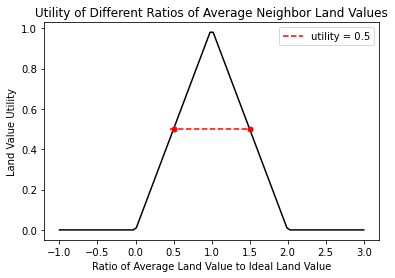

In [40]:


def theoretical_landval_happiness(av_neighbor_proportions, ideal_LV): 
    """
    Find the theoretical utility of land value similarity 
    """
    LV_utilities = []
    for proportion in av_neighbor_proportions: 
        ratio_diff = (abs(proportion*ideal_LV - ideal_LV) / ((ideal_LV)))
        LV_utilities.append(0 if ratio_diff > 1 else 1 - ratio_diff)
    return LV_utilities

av_neighbor_proportions = np.linspace(-1, 3, 100)
ideal_LV = 1

land_value_utilities = theoretical_landval_happiness(av_neighbor_proportions, ideal_LV)

plt.plot(av_neighbor_proportions, land_value_utilities, color="black")
plt.xlabel("Ratio of Average Land Value to Ideal Land Value")
plt.ylabel("Land Value Utility")
plt.plot(0.5, 0.5, marker="o", markersize=5, color="red")
plt.plot(1.5, 0.5, marker="o", markersize=5, color="red")
plt.axhline(y=0.5, xmin=3/8, xmax=5/8, color="red", linestyle="--", label="utility = 0.5")
plt.title("Utility of Different Ratios of Average Neighbor Land Values")
plt.legend()
plt.show()

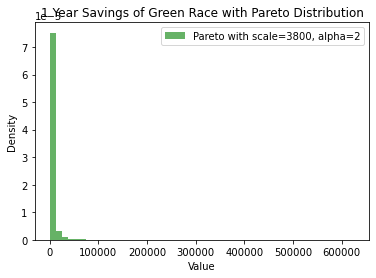

Mean: 4353.74
Median: 1649.09
Standard Deviation: 20736.67


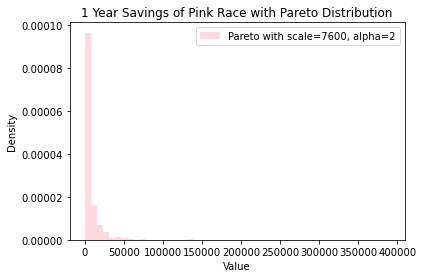

Mean: 7604.03
Median: 3249.60
Standard Deviation: 17467.32


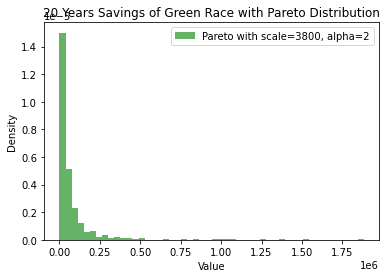

Mean: 76028.07
Median: 30713.02
Standard Deviation: 159550.47


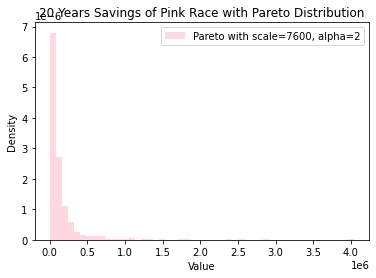

Mean: 143674.37
Median: 69644.80
Standard Deviation: 274591.51


In [61]:

def show_pareto(alpha, scale, num_samples, label_pareto, title, color, years_earned):
    """
    Show Pareto Distribution . 
    """
    pareto_samples = years_earned * (np.random.pareto(alpha, num_samples) * scale)
    plt.hist(pareto_samples, bins=50, density=True, alpha=0.6, color=color, label=label_pareto)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()
    mean = np.mean(pareto_samples)
    median = np.median(pareto_samples)
    std_dev = np.std(pareto_samples)
    print(f"Mean: {mean:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Standard Deviation: {std_dev:.2f}")

plt.subplot()
show_pareto(alpha=2.0, scale=3800, num_samples=1000, label_pareto="Pareto with scale=3800, alpha=2", title="1 Year Savings of Green Race with Pareto Distribution", color = "green", years_earned=1)
show_pareto(alpha=2.0, scale=3800*2, num_samples=1000, label_pareto="Pareto with scale=7600, alpha=2", title="1 Year Savings of Pink Race with Pareto Distribution", color = "pink", years_earned=1)

show_pareto(alpha=2.0, scale=3800, num_samples=1000, label_pareto="Pareto with scale=3800, alpha=2", title="20 Years Savings of Green Race with Pareto Distribution", color = "green", years_earned=20)
show_pareto(alpha=2.0, scale=3800*2, num_samples=1000, label_pareto="Pareto with scale=7600, alpha=2", title="20 Years Savings of Pink Race with Pareto Distribution", color = "pink", years_earned=20)
